## Data

Collection of multi-source dermatoscopic images of pigmented lesions

Original Challenge: https://challenge2018.isic-archive.com

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

### Acknowledgement
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

### Data Distribution
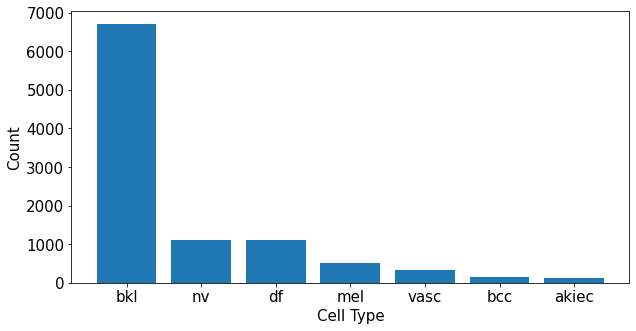

In [1]:
from keras.models import load_model
import random
import numpy as np
from tensorflow.keras.models import Model
import scipy
from matplotlib.patches import Rectangle 
from skimage.feature.peak import peak_local_max
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

model = load_model("./vgg16_GP.hdf5", compile=False)
label_list=['akiec','bcc','blk','df','mel','nv','vasc']

In [2]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
validation_generator = datagen.flow_from_directory(
    './Data/', 
    target_size=(256,384),
    batch_size=50,
    class_mode='categorical',
    subset='validation')

x, y = next(validation_generator)

Found 700 images belonging to 7 classes.


In [3]:
def heatmap_localization(image): 
    img = image
    input_img = np.expand_dims(img, axis=0) 
    pred = model.predict(input_img)
    weights = model.layers[-1].get_weights()[0] #Prediction layer
    pred_weights = weights[:, np.argmax(pred)]

    conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = conv_model.predict(input_img)
    conv_output = np.squeeze(conv_output)
    
    # resize the last conv. output to same size as original image
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    upsampled_output = scipy.ndimage.zoom(conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 pred_weights).reshape(img.shape[0],img.shape[1])

    coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    ax=plt.gca()
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,coords.shape[0]):

        b = coords[i,0]
        a = coords[i,1]
        ax.annotate(label_list[np.argmax(model.predict(input_img))], (a-25, b-25), color='black', weight='bold', fontsize=12, ha='center', va='center')
        ax.add_patch(Rectangle((a-25, b-25), 60,60,linewidth=1,edgecolor='r',facecolor='none'))

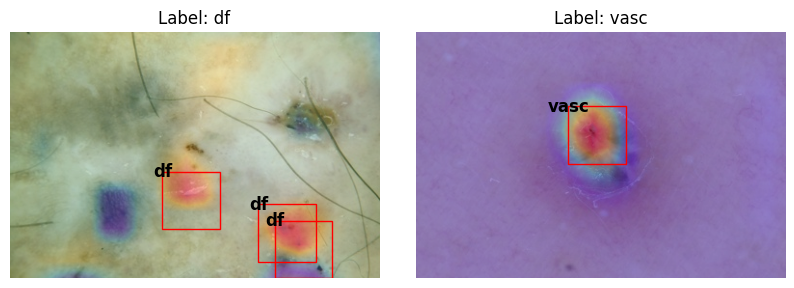

In [6]:
num = random.randint(0, len(x))
plt.figure(figsize = (10 ,4))
for i in range(2):
    plt.subplot(1 , 2, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
    heatmap_localization(x[num+i])
    plt.title('Label: {}'.format(label_list[np.argmax(y[num+i])]),fontsize = 12)
    plt.axis('off')